In [38]:
import csv

import pandas as pd

import numpy as np

import torch

from torch import nn, optim

from torch.autograd import Variable

from torch.utils.data import Dataset

from torch.utils.data import DataLoader

import time

import matplotlib.pyplot as plt

In [39]:
# 定义自己的类
class MyDataset(Dataset):
    
    # 初始化
    def __init__(self, file_name):
        # 读入数据
        self.data = pd.read_csv(file_name)
    
    # 返回df的长度
    def __len__(self):
        return len(self.data)
    
    # 获取第idx+1列的数据
    def __getitem__(self, idx):
        return self.data.values[idx,1:10]

# 通过实例化对象来访问该类
# 假设同目录下存在名为median_benchmark.csv的文件
ds = MyDataset('formatweather.csv')
ds=np.asarray(ds[:], dtype = np.float32)#####源文件float32 ,不知道为什么读取变为float64，这里再进行处理  最大最小化时变化
##dl = DataLoader(ds, batch_size=100, shuffle=False)

#####处理为torch，分为trainx，trainy
torchds=torch.from_numpy(ds[:])

In [40]:
# 定义 Recurrent Network 模型

class Rnn(nn.Module):

    def __init__(self, in_dim, hidden_dim, n_layer, n_class):

        super(Rnn, self).__init__()

        self.n_layer = n_layer

        self.hidden_dim = hidden_dim

        self.lstm = nn.LSTM(in_dim, hidden_dim, n_layer, batch_first=True)

        self.classifier = nn.Linear(hidden_dim, n_class)



    def forward(self, x):

        # h0 = Variable(torch.zeros(self.n_layer, x.size(1),

        #   self.hidden_dim)).cuda()

        # c0 = Variable(torch.zeros(self.n_layer, x.size(1),

        #   self.hidden_dim)).cuda()

        out, _ = self.lstm(x) #out 100 28 128 _ [0]2 100 128 [1]2 100 128

        out = out[:, -1, :]  #100,128

        out = self.classifier(out) #100,10

        return out


In [41]:
class Cnn(nn.Module):

    def __init__(self, in_dim, n_class):

        super(Cnn, self).__init__()

        self.conv = nn.Sequential(

            nn.Conv2d(in_dim, 6, (1,2), stride=(1), padding=(0,1)),#6,1,9

            nn.ReLU(True),

            nn.MaxPool2d(1, 1),#6,1,9

            nn.Conv2d(6, 16, (1,3), stride=(1), padding=(0,1)),

            nn.ReLU(True), nn.MaxPool2d(1, 1))#16,1,9
   
            #5*144

        self.fc = nn.Linear(144, 16)
        
        self.fc1 = nn.Linear(16, 8)
        
        self.fc2 = nn.Linear(8, n_class)



    def forward(self, x):

        out = self.conv(x)

        out = out.view(out.size(0), -1)

        out = self.fc(out)
        
        out1=self.fc1(out)
        
        out=self.fc2(out1)

        return out1

In [42]:
cnnmodel = Cnn(1, 1)
cnnmodel.load_state_dict(torch.load('./weathercnn-0.01-true-7.14.pth'))


cnnmodel.eval()
    
test_x=torchds[:30700,0:8]

test_x=test_x.view(-1,1,1,8)

test_y=torchds[:30700,8]

test_y=test_y.view(-1,1)

test_x=Variable(test_x)

test_y=Variable(test_y)

cnnout = cnnmodel(test_x) #####8

In [43]:
rnnmodel = Rnn(8, 4, 2, 1)  
##model.load_state_dict(torch.load('./weathercnn.pth'))
criterion = nn.MSELoss()
optimizer = optim.SGD(rnnmodel.parameters(), lr=0.01) ####速度很快

In [44]:
train_dataset =cnnout  ##0.7*43823  8
test_dataset  =test_y
dltrain = DataLoader(train_dataset, batch_size=100, shuffle=False)
dltest  = DataLoader(test_dataset, batch_size=100, shuffle=False)

In [45]:
cnnout.size()

torch.Size([30700, 8])

epoch 1
**********
running_loss:-------
0.008310387454598387
epoch 2
**********
running_loss:-------
0.008310150374487386
epoch 3
**********
running_loss:-------
0.008309914172172084
epoch 4
**********
running_loss:-------
0.008309679171551097
epoch 5
**********
running_loss:-------
0.008309445288873887
epoch 6
**********
running_loss:-------
0.008309212462845845
epoch 7
**********
running_loss:-------
0.008308980717161232
epoch 8
**********
running_loss:-------
0.008308750380594978
epoch 9
**********
running_loss:-------
0.00830852078179779
epoch 10
**********
running_loss:-------
0.008308292304363132
epoch 11
**********
running_loss:-------
0.00830806502176751
epoch 12
**********
running_loss:-------
0.008307838839198323
epoch 13
**********
running_loss:-------
0.008307613703543451
epoch 14
**********
running_loss:-------
0.00830738967556425
epoch 15
**********
running_loss:-------
0.008307166497171602
epoch 16
**********
running_loss:-------
0.008306944599608197
epoch 17
**********


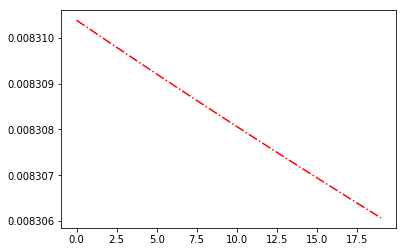

Wall time: 1min 26s


In [49]:
%%time 
losslist=[]
for epoch in range(20):
 
    print('epoch {}'.format(epoch + 1))

    print('*' * 10)

    running_loss = 0.0
    
    dldata=zip(dltrain,dltest)  #cnnout,trainy0.7

    for i, data in enumerate(dldata, 1):
        
            train_x=data[0][:,:]
            
            train_x=train_x.view(-1,1,8)
            
            train_y=data[1][:,0]
            
            train_y=train_y.view(-1,1)
            
            train_x=Variable(train_x)
            
            train_y=Variable(train_y)
        
            out = rnnmodel(train_x)

            loss = criterion(out, train_y)
            
            running_loss += loss.item() * train_y.size(0)
            

            # 向后传播

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
            
    losslist.append(running_loss / (len(train_dataset)))   
           
                
    print('running_loss:-------')
    print(running_loss / (len(train_dataset)))  
    
plt.plot(losslist,'r-.') 
plt.show()

In [48]:
x=range(0,100)
plt.figure(num=1,figsize=(18,5))#定义编号为1 大小为(8,5)
plt.plot(x,train_y.numpy(),'r-.',label='train_y') 
plt.plot(x,out.detach().numpy(),'b-.',label='out') 
plt.legend(loc='best')#显示在最好的位置
plt.show()

NameError: name 'train_y' is not defined

<Figure size 1296x360 with 0 Axes>

In [ ]:
rnnmodel.eval()
    
test_x=torchds[30700:,0:8]

test_x=test_x.view(-1,1,8)

test_y=torchds[30700:,8]

test_y=test_y.view(-1,1)

test_x=Variable(test_x)

test_y=Variable(test_y)

testout = cnnmodel(test_x)

lstmtestout=rnnmodel(testout)



In [ ]:
#x=range(0,13123)
x=range(1200,1300)
plt.figure(num=1,figsize=(18,5))#定义编号为1 大小为(8,5)
plt.plot(x,test_y.detach().numpy()[1200:1300],'r-.',label='test_y') 
plt.plot(x,out.detach().numpy()[1200:1300],'b-.',label='out') 
plt.legend(loc='best')#显示在最好的位置
plt.show()